In [1]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fastai.vision import *

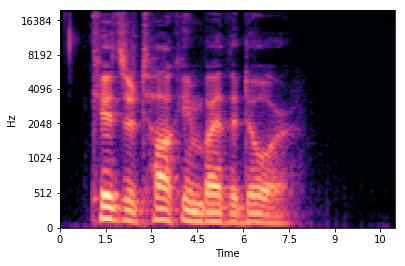

In [2]:
y, sr = librosa.load("storage/ravdess/Actor_01/03-01-01-01-01-01-01.wav")
yt, _ = librosa.effects.trim(y)
y = yt

mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time')

In [3]:
path=Path('storage/ravdess_mod')

In [4]:
path.ls()

[PosixPath('storage/ravdess_mod/sad'),
 PosixPath('storage/ravdess_mod/happy'),
 PosixPath('storage/ravdess_mod/.ipynb_checkpoints'),
 PosixPath('storage/ravdess_mod/calm'),
 PosixPath('storage/ravdess_mod/surprised'),
 PosixPath('storage/ravdess_mod/disgust'),
 PosixPath('storage/ravdess_mod/angry'),
 PosixPath('storage/ravdess_mod/fearful'),
 PosixPath('storage/ravdess_mod/models'),
 PosixPath('storage/ravdess_mod/neutral')]

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, size=144, num_workers=4).normalize(imagenet_stats)

In [6]:
data.classes

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [7]:
data?

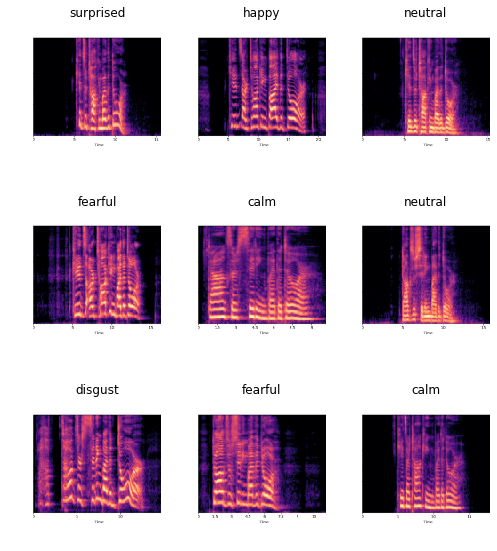

In [8]:
data.show_batch(rows=3, figsize=(7,8))

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [10]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,3.038543,1.822066,0.423611,00:09
1,2.267014,1.750739,0.458333,00:07
2,1.755980,1.664796,0.506944,00:07
3,1.365257,1.682141,0.510417,00:07
4,1.099593,1.646936,0.510417,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


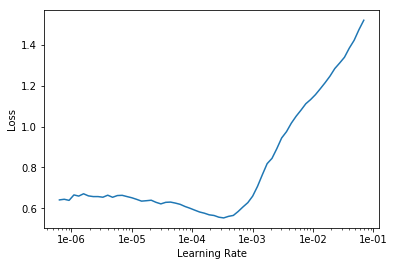

In [11]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(5, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.625692,1.602869,0.534722,00:08
1,0.500790,1.548435,0.545139,00:08
2,0.390853,1.523125,0.579861,00:08
3,0.296043,1.332621,0.611111,00:08
4,0.219409,1.326187,0.611111,00:09


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


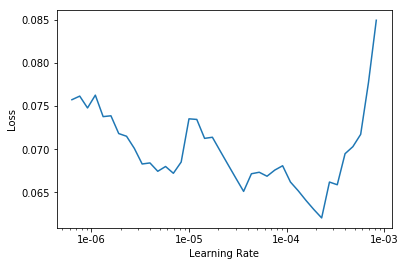

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.062294,1.295990,0.604167,00:09
1,0.055191,1.278794,0.631944,00:09
2,0.042434,1.299456,0.638889,00:08
3,0.035336,1.287941,0.645833,00:08
4,0.030849,1.303326,0.642361,00:09


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


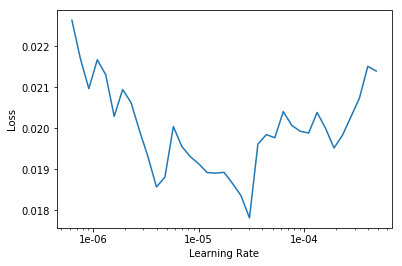

In [15]:
learn.lr_find()
learn.recorder.plot()

The loss is decreasing, but the accuracy isn't improving. And the validation loss is also quite high at the moment. Will try to use some augmentation for this. I will also try to use a different pre-trained model (resnet50)

In [24]:
tfms = get_transforms(do_flip=False,flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.,max_rotate=5)

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=tfms, size=144, num_workers=4).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [25]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,3.093465,2.072528,0.298611,00:10
1,2.712272,1.695543,0.461806,00:09
2,2.412678,1.504040,0.503472,00:08
3,2.187899,1.492590,0.552083,00:08
4,2.017228,1.459562,0.552083,00:08


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


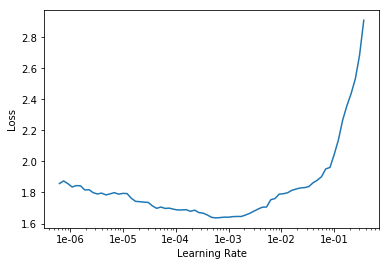

In [26]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(5, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.736696,1.321386,0.572917,00:11
1,1.635344,1.257875,0.583333,00:08
2,1.419718,1.227257,0.614583,00:08
3,1.238412,1.106124,0.656250,00:08
4,1.095212,1.098359,0.663194,00:08


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


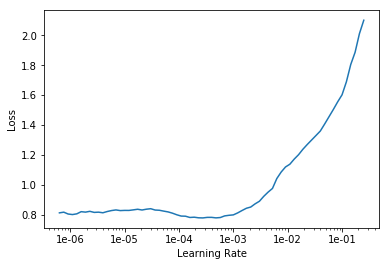

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(10, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.798655,1.061206,0.670139,00:10
1,0.747886,1.126012,0.652778,00:09
2,0.679231,1.165846,0.673611,00:08
3,0.631926,1.054083,0.687500,00:08
4,0.560904,1.065009,0.684028,00:08
5,0.498411,0.997947,0.718750,00:09
6,0.424519,0.977557,0.736111,00:08
7,0.352360,0.980906,0.736111,00:09
8,0.312334,0.966675,0.739583,00:09
9,0.275010,0.948101,0.736111,00:09


The accuracy is decent, but the validation loss is quite higher than the training loss. At this stage we will stop training. Freeze the model. And use it for prediction on a sample input. We will just check the confusion matrix to see which emotions the model is struggling with (heh).

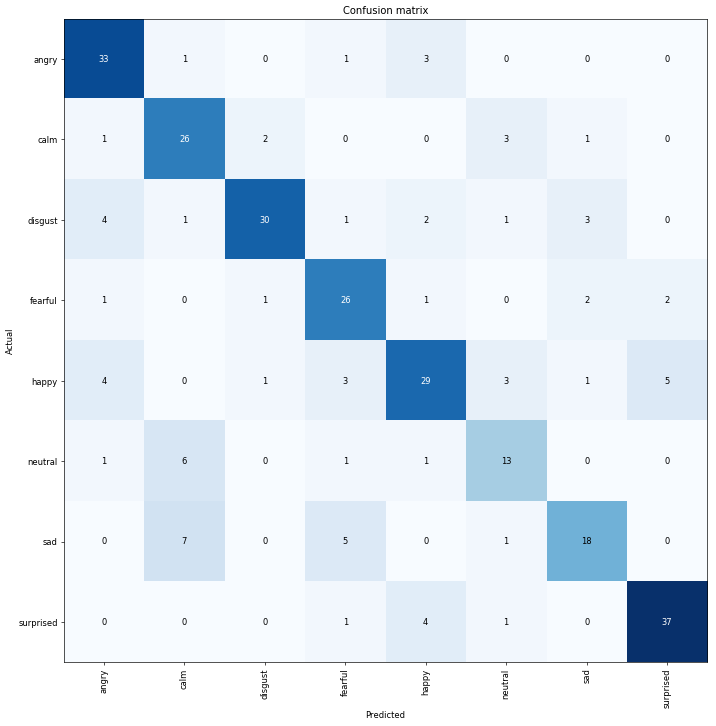

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [32]:
learn.save(Path("/notebooks/model_unfrozen"), return_path=True)

PosixPath('/notebooks/model_unfrozen.pth')

In [33]:
learn.freeze()
learn.save(Path("/notebooks/model_frozen"), return_path=True)

PosixPath('/notebooks/model_frozen.pth')

In [34]:
learn.export("model_export")